# Лабораторная работа №1
## Метрические алгоритмы

1)  применить метод k ближайших соседей, взвешенный ядерный,  с алгоритмом STOLP для 5 классов сгенерированных с помощью make_classification

2) для сгенерированного нами датасета построить профиль компактности

3) для сгенерированного датасета произвести оптимизацию выбора ширины окна (можно метод меняющегося окна)

4) найти датасет с картинками, небольшой с 2-3 классами (100 размеченных хватит), найти метод/библиотеку для построения embeddingов над картинками (image embeddings), применить embedding к картинкам, чтобы каждой соответствовал вектор, после этого применить knn для полученного датасета из векторизованных картинок

5*) если получится подобрать датасет с несуществующими в реальной жизни объектами на картинках, после 4го пункта, взять на своих двух картинках и прогнать через обученный knn

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KernelDensity
import matplotlib.pyplot as plt
import math
import numpy as np
from mlxtend.plotting import plot_decision_regions

#### Генерация тестовых данных

In [3]:
X, y = make_classification(600, n_features=3, n_redundant=0, n_informative=3, n_classes=5, n_clusters_per_class=1)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [4]:
def do_plot(X,y):
  fig = plt.figure(figsize=(6, 6))
  px = fig.add_subplot(111, projection='3d')
  plt.scatter(X[:, 0], X[:, 1],  marker="o", c=y, s=25)
  plt.show()

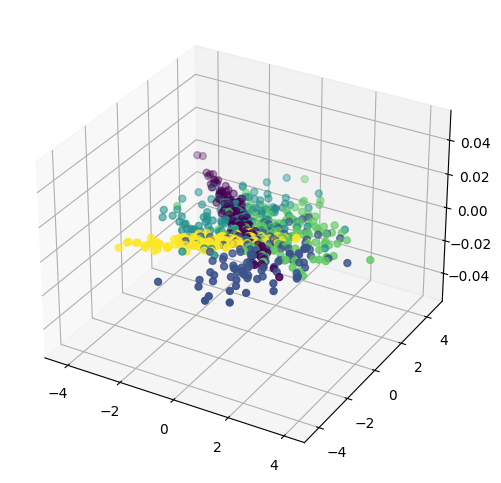

In [5]:
do_plot(X,y)

#### Применение метода k ближайших соседей с n соседей

In [6]:
# ядро Гаусса
def Gauss(r):
    """
      Calculates the Gaussian function for a given input.

      Parameters:
      r (float): Input value for the Gaussian function.

      Returns:
        float: The result of the Gaussian function for the given input.
    """
    return ((2 * np.pi)**(-1/2)) * np.exp(-1/2 * (r**2))

In [7]:
def KNeighbors(x_i, k, X_train, y_train, h = 1, prob = False):
    """
      Calculates the k-nearest neighbors for a given input.

      Parameters:
        x_i (array): The input array for which the k-nearest neighbors need to be found.
        k (int): The number of nearest neighbors to be found.
        X_train (array): The input data used to train the model.
        y_train (array): The output data used to train the model.
        h (float): The scaling factor for the Gaussian function. Default value is 1.
        probability (bool): Flag to indicate whether to return the probabilities of each class. Default value is False.

      Returns:
        int or array: If probability is False, returns the predicted class for the input array. If probability is True, returns the probabilities of each class.
    """
    point_index = np.arange(len(y_train))
    data = [(i, y, math.dist(x_i,x)) for i, x, y in zip(point_index, X_train, y_train)]
    data = np.array(data, [('ind', int), ('y', int), ('distance', float)])
    data = np.sort(data, order=['distance'])

    KNeighbor = np.array([sorted([i['distance'] for i in data if i['y'] == j][:k]) for j in range(max(y_train)+1)])

    if not prob:
        return np.argmax(np.sum(Gauss(KNeighbor/h), axis=1))
    else:
        return np.sum(Gauss(KNeighbor/h), axis=1)

In [8]:
def STOLP(X_train, y_train, N):
    _, counts = np.unique(y_train, return_counts=True)
    k = min(counts)
    data = [np.array([(i, max(KNeighbors(X_train[i], k, X_train, y_train, h=1, prob=True))) for i in range(len(X_train)) if y_train[i] == j], dtype=[('ind', int), ('distance', float)]) for j in range(max(y_train)+1)]
    ref = [np.sort(d, order=['distance'])[:N] for d in data]
    X_out, Y_out = [], []
    for i, d in enumerate(ref):
        for j, item in enumerate(d):
            X_out.append(X_train[item[0]])
            Y_out.append(i)
    return np.array(X_out), np.array(Y_out)

In [9]:
iterations = 200
X_out, y_out = STOLP(X_train, y_train, iterations)

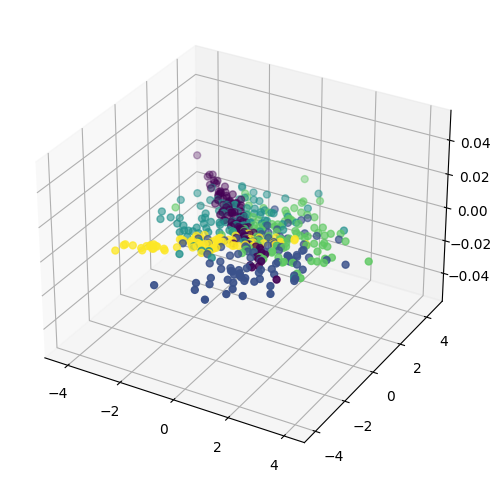

In [10]:
do_plot(X_out, y_out)

Тестовые данные

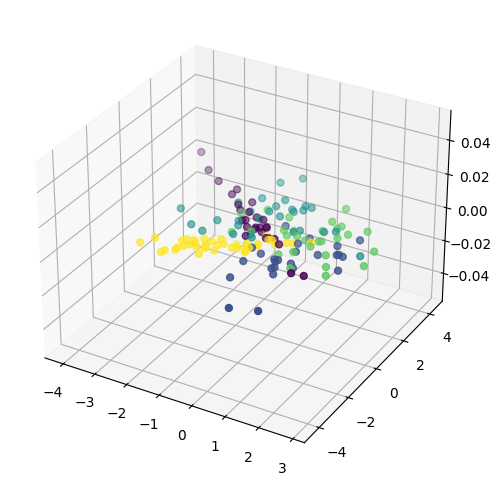

In [11]:
do_plot(X_test, y_test)

In [12]:
def accuracy_score(X_train, y_train, k, h, X_test, y_test):
    predicted_labels =[]
    for x, y in zip(X_test, y_test):
      predicted_label = KNeighbors(x, k, X_train, y_train, h)
      predicted_labels.append(predicted_label == y)
    return np.mean(predicted_labels)

acc_scores = []
k_range = [i for i in range(70)]
for i in k_range:
  acc_scores.append(accuracy_score(X_out, y_out, i, 1, X_test, y_test))

In [13]:
best_acc = max(acc_scores)
best_k = acc_scores.index(best_acc)
print(f"Наилучший acc: {best_acc} при k = {best_k}")

Наилучший acc: 0.8066666666666666 при k = 3


In [14]:
y_pred = []
for i in range(len(X_test)):
  y_pred.append(KNeighbors(X_test[i], best_k, X_test, y_test, h=1))

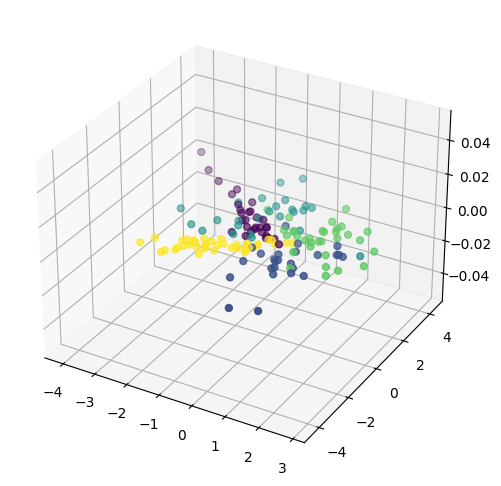

In [15]:
do_plot(X_test, y_pred)

## Профиль компактности

In [16]:
def compact_profile(X, Y, N):
  R = []
  for j in range(N):
      R_j = 0
      for x_i, y_i in zip(X, Y):
          ind = np.arange(len(Y))
          data = [(y, math.dist(x_i,x)) for x, y in zip(X, Y)]
          data = np.array(data, dtype=[('y', int), ('distance', float)])
          data = np.sort(data, order=['distance'])
          R_j += data[j]['y'] != y_i
      R.append(R_j / len(Y))
  return R

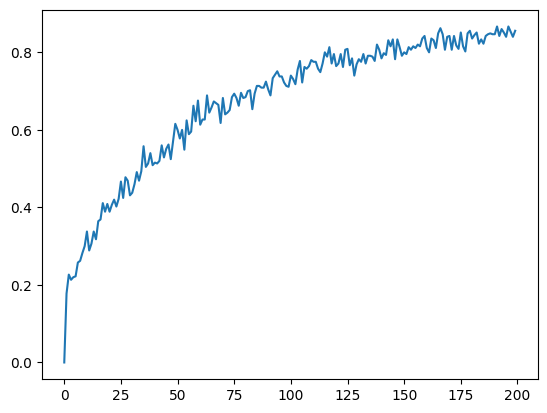

In [17]:
plt.plot(compact_profile(X_train, y_train, 200))
plt.show()

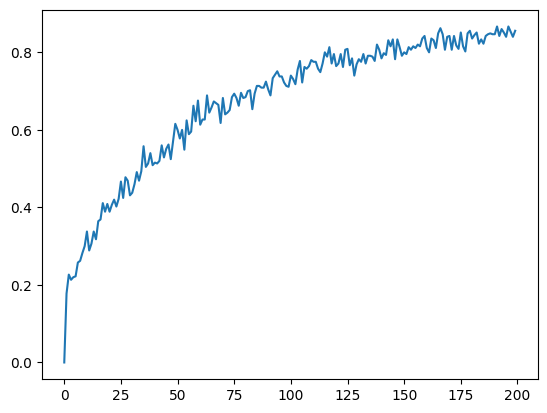

In [18]:
plt.plot(compact_profile(X_out, y_out, 200))
plt.show()

## Оптимизация выбора ширины окна

In [19]:
def optimize_h(X_train, y_train, k, X_test, y_test):
    h_range = [i for i in np.arange(0.1, 50.0, 0.1)]
    acc = 0
    best_h = h_range[0]
    for h in h_range:
      tmp = accuracy_score(X_train, y_train, k, h, X_test, y_test)
      if tmp > acc:
        acc = tmp
        best_h = h
    return best_h

In [20]:
best_h = optimize_h(X_train, y_train, best_k, X_test, y_test)

In [21]:
acc_scores_with_best_h = []
acc_scores_with_best_h.append(accuracy_score(X_out, y_out, best_k, best_h, X_test, y_test))
best_acc_with_best_h = max(acc_scores_with_best_h)

In [22]:
print(f"Лучший размер окна h = {best_h} при лучшей точности {best_acc_with_best_h} при k = {best_k}")

Лучший размер окна h = 0.8 при лучшей точности 0.8066666666666666 при k = 3


## Векторизированные картинки

In [23]:
# HuggingFace datasets
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.8 MB/s eta 0:00:00


In [25]:
from datasets import load_dataset

In [26]:
dataset = load_dataset('cifar10')

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:325: UserWarning: Downcasting array dtype uint8 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
X_train, y_train, X_test, y_test = dataset['train']['img'],  dataset['train']['label'], dataset['test']['img'], dataset['test']['label']

In [28]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [29]:
# загрузка предобученной ResNet50
model = ResNet50(weights='imagenet', include_top=False)

# извлечение признаков из изображений
features = []
for image in X_train[:3000]:
    # изменение размера изображения до 224х224 (размер входа в ResNet50)
    resized_image = image.resize((224, 224))
    img_array = img_to_array(resized_image)
    img_array = np.expand_dims(img_array, axis=0)
    # преобразование и нормализация изображения
    img_array = preprocess_input(img_array)
    # извлечение признаков и приведение к двумерному массиву
    feature = model.predict(img_array).ravel()
    # извлечение признаков
    features.append(feature)

pca = PCA(n_components=20)
features = pca.fit_transform(features)

# применение метода ближайших соседей
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(features, y_train[:3000])

1/1 [==============================] - 0s 192ms/step


KNeighborsClassifier(n_neighbors=3)

In [30]:
from sklearn.metrics import accuracy_score

y_pred = []
for image in X_test[:1000]:
    resized_image = image.resize((224, 224))
    img_array = img_to_array(resized_image)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    # извлечение признаков
    test_img_features = pca.transform(model.predict(img_array)[0].reshape(1, -1))
    predicted_label = knn.predict(test_img_features)
    y_pred.append(predicted_label)

1/1 [==============================] - 0s 197ms/step


In [31]:
accuracy = accuracy_score(y_pred, y_test[:1000])
print("Accuracy:", accuracy)

Accuracy: 0.803


## Применение к своим фото

In [33]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=a7e5d3b46add858eab733923d522ba37021c82626a56b11b9e1508dc3cbcf604
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [34]:
import wget

img_1 = wget.download('https://wallpapers.com/images/hd/flight-29hfv3pcr55o0h83.jpg') # plane
img_2 = wget.download('https://w.forfun.com/fetch/64/64187c59709bf896d9e321eb53b71c56.jpeg') # auto

In [37]:
from PIL import Image

img_1 = Image.open(img_1)
img_2 = Image.open(img_2)

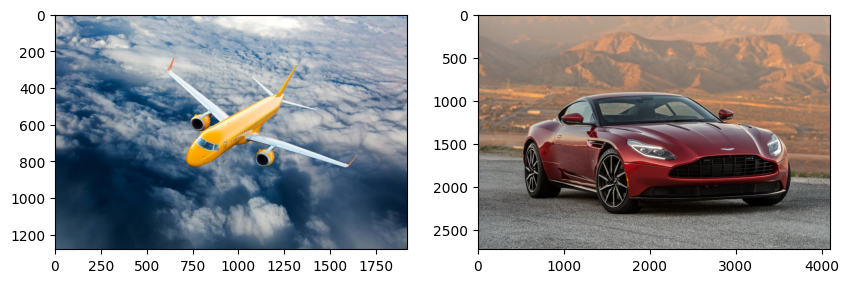

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].imshow(img_1)
ax[1].imshow(img_2)

plt.show()

In [45]:
images_user = [img_1, img_2]
labels_user = [0, 1]
y_pred_user = []
for image in images_user:
    resized_image = image.resize((224, 224))
    img_array = img_to_array(resized_image)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    # извлечение признаков
    test_img_features = pca.transform(model.predict(img_array)[0].reshape(1, -1))
    predicted_label = knn.predict(test_img_features)
    y_pred_user.append(predicted_label)

accuracy_user = accuracy_score(y_pred_user, labels_user)
print("User acc: ", accuracy_user)

<class 'PIL.PngImagePlugin.PngImageFile'>
1/1 [==============================] - 0s 211ms/step
User acc:  1.0
